Original notebook from: https://github.com/jakevdp/PracticalLombScargle/blob/master/figures/LINEAR_Example.ipynb

Obect info: http://simbad.u-strasbg.fr/simbad/sim-id?Ident=linear+11375941&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id

# Lomb-Scargle Example Dataset

## The Data

For simplicity, we download the data here and save locally

In [1]:
!pip install astroML

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 2.4 MB/s eta 0:00:00


In [2]:
import pandas as pd

def get_LINEAR_lightcurve(lcid):
    from astroML.datasets import fetch_LINEAR_sample
    LINEAR_sample = fetch_LINEAR_sample()
    data = pd.DataFrame(LINEAR_sample[lcid],
                        columns=['t', 'mag', 'magerr'])
    data.to_csv('LINEAR_{0}.csv'.format(lcid), index=False)

# Uncomment to download the data
get_LINEAR_lightcurve(lcid=11375941)

In [3]:
data = pd.read_csv('LINEAR_11375941.csv')
data.head()

,t,mag,magerr
0,52650.434545,15.969,0.035
1,52650.448450,16.036,0.039
2,52650.462420,15.990,0.035
3,52650.476485,16.027,0.035
4,52650.490443,15.675,0.030


In [ ]:
data.shape

(280, 3)

In [ ]:
(data.t.max() - data.t.min()) / 365.

5.374924287671237

## Visualizing the Data

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

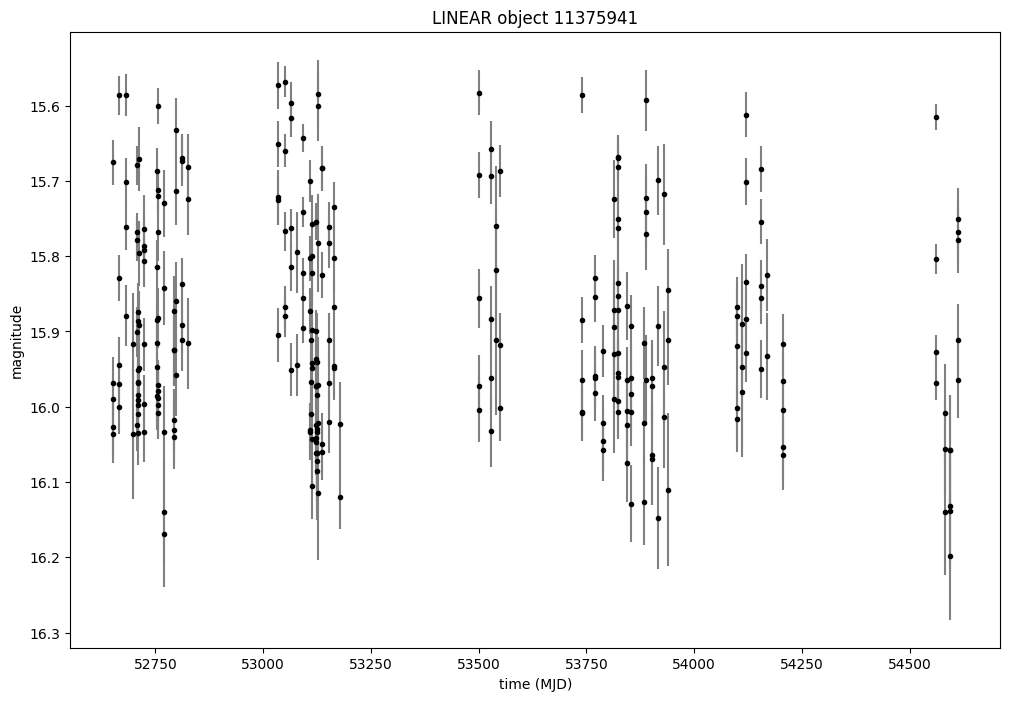

In [5]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(data.t, data.mag, data.magerr,
            fmt='.k', ecolor='gray', capsize=0)
ax.set(xlabel='time (MJD)',
       ylabel='magnitude',
       title='LINEAR object 11375941')
ax.invert_yaxis()

#fig.savefig('fig01_LINEAR_data.pdf');

In [6]:
from astropy.timeseries import LombScargle
ls = LombScargle(data.t, data.mag, data.magerr)
frequency, power = ls.autopower(nyquist_factor=500,
                                minimum_frequency=0.2)

period_days = 1. / frequency
period_hours = period_days * 24

In [7]:
best_period = period_days[np.argmax(power)]

phase = (data.t / best_period) % 1

print("Best period: {0:.2f} hours".format(24 * best_period))

Best period: 2.58 hours


[(1.0, 5.0), Text(0.5, 0, 'Period (hours)'), Text(0, 0.5, 'power')]

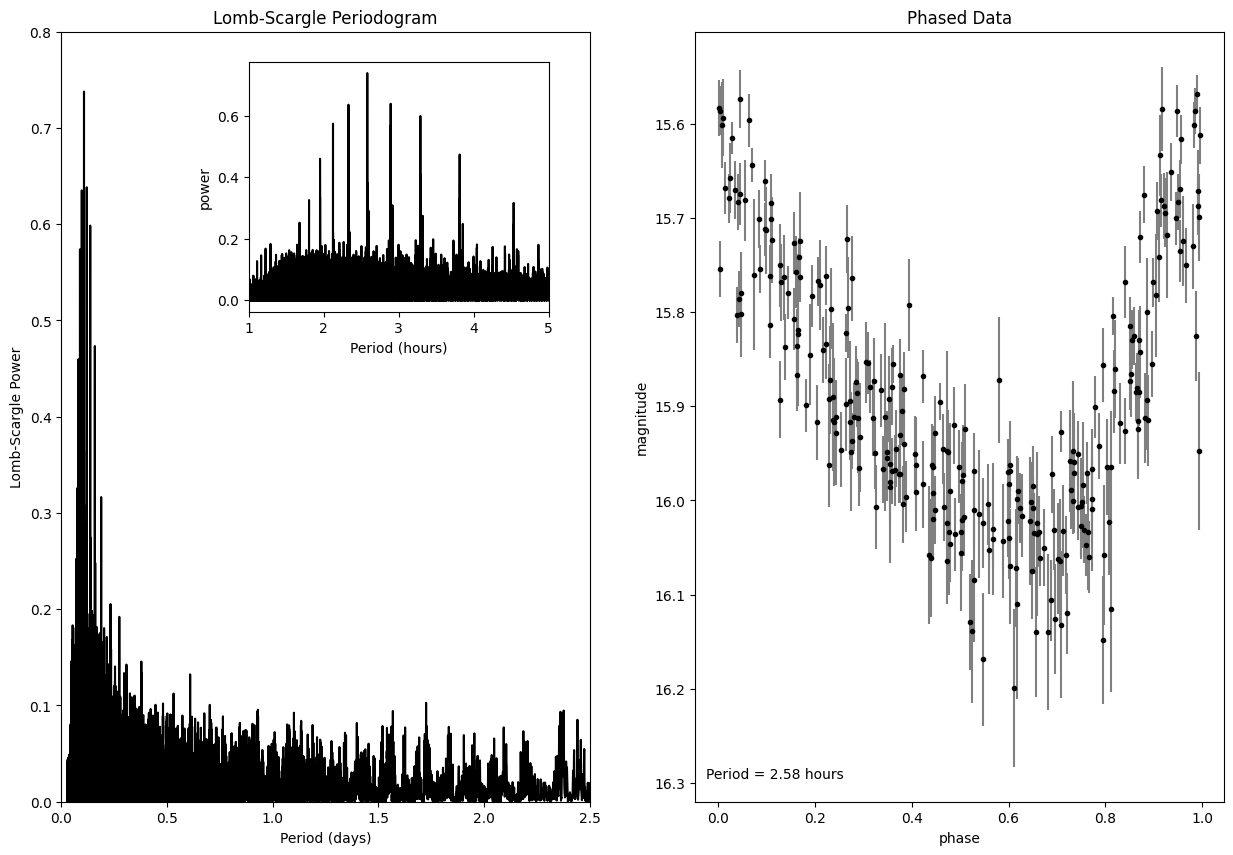

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

# PSD has a _LOT_ of elements. Rasterize it so it can be displayed as PDF
ax[0].plot(period_days, power, '-k', rasterized=True)

ax[0].set(xlim=(0, 2.5), ylim=(0, 0.8),
          xlabel='Period (days)',
          ylabel='Lomb-Scargle Power',
          title='Lomb-Scargle Periodogram')

ax[1].errorbar(phase, data.mag, data.magerr,
               fmt='.k', ecolor='gray', capsize=0)
ax[1].set(xlabel='phase',
          ylabel='magnitude',
          title='Phased Data')
ax[1].invert_yaxis()
ax[1].text(0.02, 0.03, "Period = {0:.2f} hours".format(24 * best_period),
           transform=ax[1].transAxes)

inset = fig.add_axes([0.25, 0.6, 0.2, 0.25])
inset.plot(period_hours, power, '-k', rasterized=True)
inset.xaxis.set_major_locator(plt.MultipleLocator(1))
inset.yaxis.set_major_locator(plt.MultipleLocator(0.2))
inset.set(xlim=(1, 5),
          xlabel='Period (hours)',
          ylabel='power')

#fig.savefig('fig02_LINEAR_PSD.pdf');

## Peak Precision

Estimate peak precision by plotting the Bayesian periodogram peak.

Best period: 2.58065, Median period: 2.57926
5 and 95% percentiles: 2.57801 2.58051
0.0012455825433645984 0.001246786755375151


<ipython-input-9-40bed64dbfb2>:7: RuntimeWarning: overflow encountered in exp
  P = np.exp(P)
<ipython-input-9-40bed64dbfb2>:8: RuntimeWarning: invalid value encountered in divide
  P /= P.max()


(2.58, 2.5803)

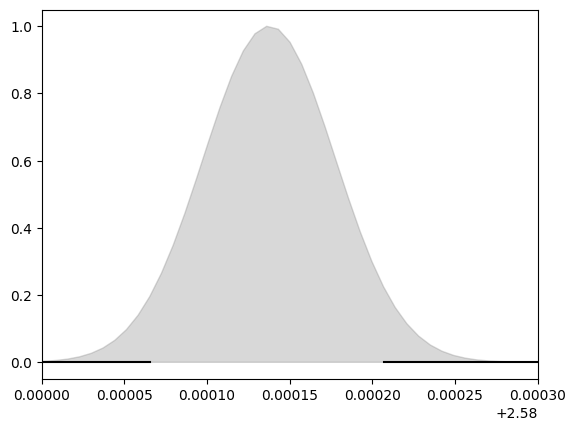

In [9]:
f, P = ls.autopower(nyquist_factor=500,
                    minimum_frequency=9.3,
                    maximum_frequency=9.31,
                    samples_per_peak=20,
                    normalization='psd')

P = np.exp(P)
P /= P.max()
h = 24. / f
pm,PMed,pM = np.nanpercentile(h, [5,50,95])
PMax = h.max()
print("Best period: {:.5f}, Median period: {:.5f}".format(PMax,PMed))
print("5 and 95% percentiles: {:.5f} {:.5f}".format(pm,pM))
print(PMed-pm,pM-PMed)


plt.plot(h, P, '-k')
plt.fill(h, np.exp(-0.5 * (h - 24*best_period) ** 2 / 0.00004 ** 2), color='gray', alpha=0.3)
plt.xlim(2.58, 2.5803)

Looks like $2.57296 \pm 0.0012$ hours

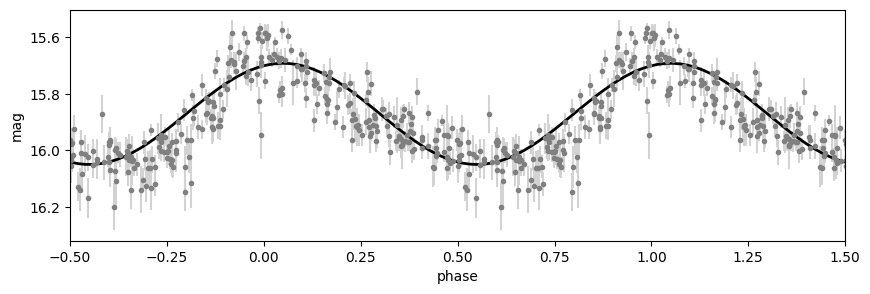

In [10]:
fig, ax = plt.subplots(figsize=(10, 3))

phase_model = np.linspace(-0.5, 1.5, 100)
best_frequency = frequency[np.argmax(power)]
mag_model = ls.model(phase_model / best_frequency, best_frequency)

for offset in [-1, 0, 1]:
    ax.errorbar(phase + offset, data.mag, data.magerr, fmt='.',
                color='gray', ecolor='lightgray', capsize=0);
ax.plot(phase_model, mag_model, '-k', lw=2)
ax.set(xlim=(-0.5, 1.5),
       xlabel='phase',
       ylabel='mag')
ax.invert_yaxis()

#fig.savefig('fig18_ls_model.pdf')